Discretized States: {0: [(0.0, -3.0), (0.0, -2.0), (0.0, -1.0), (0.0, 0.0), (0.0, 1.0), (0.0, 2.0), (0.0, 3.0)], 1: [(1.5, -3.0), (1.5, -2.0), (1.5, -1.0), (1.5, 0.0), (1.5, 1.0), (1.5, 2.0), (1.5, 3.0)], 2: [(3.0, -3.0), (3.0, -2.0), (3.0, -1.0), (3.0, 0.0), (3.0, 1.0), (3.0, 2.0), (3.0, 3.0)], 3: [(4.5, -3.0), (4.5, -2.0), (4.5, -1.0), (4.5, 0.0), (4.5, 1.0), (4.5, 2.0), (4.5, 3.0)], 4: [(6.0, -3.0), (6.0, -2.0), (6.0, -1.0), (6.0, 0.0), (6.0, 1.0), (6.0, 2.0), (6.0, 3.0)], 5: [(7.5, -3.0), (7.5, -2.0), (7.5, -1.0), (7.5, 0.0), (7.5, 1.0), (7.5, 2.0), (7.5, 3.0)], 6: [(9.0, -3.0), (9.0, -2.0), (9.0, -1.0), (9.0, 0.0), (9.0, 1.0), (9.0, 2.0), (9.0, 3.0)]}
After iteration 1:
State: (1.5, -3.0), Cost: inf
State: (1.5, -2.0), Cost: inf
State: (1.5, -1.0), Cost: 1.8027756377319946
State: (1.5, 0.0), Cost: 1.5
State: (1.5, 1.0), Cost: 1.8027756377319946
State: (1.5, 2.0), Cost: inf
State: (1.5, 3.0), Cost: inf
After iteration 2:
State: (3.0, -3.0), Cost: 4.854101966249685
State: (3.0, -2.0

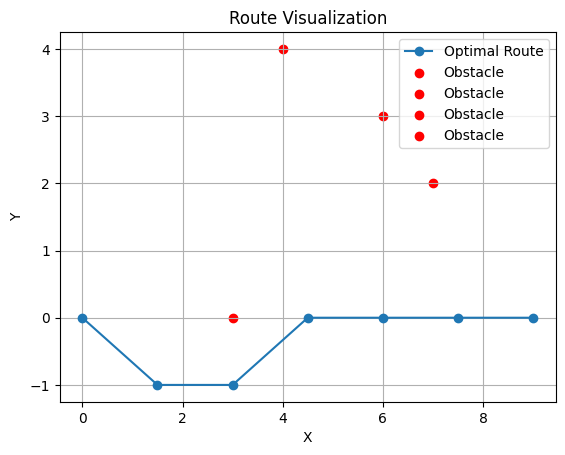

Greedy approach failed due to a collision.

Greedy Route: [(0, 0), (1.5, 0.0)]
Greedy Cost: inf


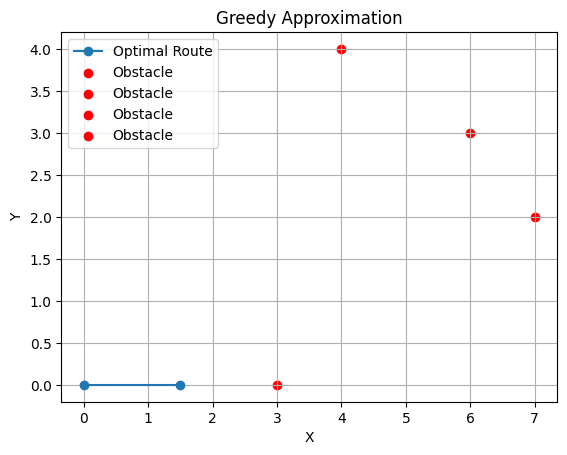

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Obstacle:
    def __init__(self, initial_position, velocity, safe_distance):
        self.initial_position = np.array(initial_position)
        self.velocity = np.array(velocity)
        self.safe_distance = safe_distance

    def position_at_time(self, t):
        return self.initial_position + self.velocity * t

    def distance_to(self, position, t):
        return np.linalg.norm(self.position_at_time(t) - np.array(position))

class ShipRoute:
    def __init__(self, start_point, ex, ey, delta_x, delta_y, N, D, speed, obstacles):
        self.start_point = np.array(start_point)
        self.ex = np.array(ex)
        self.ey = np.array(ey)
        self.delta_x = delta_x
        self.delta_y = delta_y
        self.N = N
        self.D = D
        self.speed = speed
        self.obstacles = obstacles
        self.states = {}
        self.costs = {}
        self.predecessors = {}
        self.discretize()

    def discretize(self):
        for i in range(self.N + 1):
            row_states = []
            for j in range(-self.D, self.D + 1):
                state = self.start_point + i * self.delta_x * self.ex + j * self.delta_y * self.ey
                row_states.append(tuple(state))
                self.costs[tuple(state)] = float('inf')
                self.predecessors[tuple(state)] = None
            self.states[i] = row_states
        print("Discretized States:", self.states)

    def distance(self, s1, s2):
        return np.linalg.norm(np.array(s1) - np.array(s2))

    def dynamic_programming(self):
        self.costs[tuple(self.start_point)] = 0

        for i in range(1, self.N + 1):
            for s_curr in self.states[i]:
                for s_prev in self.states[i - 1]:
                    if self.is_feasible(s_prev, s_curr, i):
                        cost = self.transition_cost(s_prev, s_curr)
                        total_cost = self.costs[s_prev] + cost

                        if total_cost < self.costs[s_curr]:
                            self.costs[s_curr] = total_cost
                            self.predecessors[s_curr] = s_prev

            # Debugging: print costs at each step
            print(f"After iteration {i}:")
            for state in self.states[i]:
                print(f"State: {state}, Cost: {self.costs[state]}")

        # Finding the final state with the minimum cost
        final_state = min(self.states[self.N], key=lambda s: self.costs[s])
        return final_state, self.costs[final_state]

    def is_feasible(self, s_prev, s_curr, t):
        for obstacle in self.obstacles:
            if obstacle.distance_to(s_curr, t) < obstacle.safe_distance:
                return False  # Collision

        #if not self.tlink(s_prev, s_curr):
         #   return False
        if not self.tθ(s_prev, s_curr):
            return False

        return True

    #def tlink(self, s_prev, s_curr):
     #   return s_prev[1] == s_curr[0]  # Ensure y-coordinate of s_prev matches x-coordinate of s_curr

    def tθ(self, s_prev, s_curr):
        θmin = np.deg2rad(15)  # Minimum threshold
        θmax = np.deg2rad(45)  # Maximum threshold

        course_prev = np.arctan2(s_prev[1], s_prev[0])
        course_curr = np.arctan2(s_curr[1], s_curr[0])

        delta_theta = np.abs(course_curr - course_prev)
        delta_theta = (delta_theta + np.pi) % (2 * np.pi) - np.pi
        delta_theta_deg = np.rad2deg(delta_theta)

        return (θmin <= delta_theta <= θmax) or (delta_theta_deg == 0)

    def transition_cost(self, s_prev, s_curr):
        return self.distance(s_prev, s_curr)

    def backtrack(self, final_state):
        route = []
        state = final_state
        while state is not None:
            route.append(state)
            state = self.predecessors[state]
        return route[::-1]

    def greedy_approximation(self):
        """ Greedy approximation to find a path to the destination. """
        current_state = tuple(self.start_point)
        route = [current_state]

        for i in range(1, self.N + 1):
            next_state = min(self.states[i], key=lambda s: self.distance(current_state, s))
            if not self.is_feasible(current_state, next_state, i):
                print("Greedy approach failed due to a collision.")
                return route, float('inf')  # Return incomplete route and high cost

            route.append(next_state)
            current_state = next_state

        return route, self.costs[current_state]

    def visualize(self, route, obstacles=None, title="Route Visualization"):
        x_route, y_route = zip(*route)
        plt.plot(x_route, y_route, marker='o', label="Optimal Route")

        if obstacles:
            for obstacle in obstacles:
                plt.scatter(*obstacle.initial_position, color='red', label="Obstacle")

        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
start_point = [0, 0]
ex = [1, 0]
ey = [0, 1]
delta_x = 1.5
delta_y = 1.0
N = 6
D = 3

obstacles = [
    Obstacle([3, 0], [-0.3, 0], 0.7),
    Obstacle([4, 4], [-0.5, -0.5], 0.5),
    Obstacle([7, 2], [0, 0], 0.8),
    Obstacle([6, 3], [-0.1, 0.1], 0.5)
]

ship_route = ShipRoute(start_point, ex, ey, delta_x, delta_y, N, D, 1.5, obstacles)

final_state, final_cost = ship_route.dynamic_programming()
print("\nOptimal Final State:", final_state)
print("Optimal Cost:", final_cost)

optimal_route = ship_route.backtrack(final_state)
print("Optimal Route:", optimal_route)

ship_route.visualize(optimal_route, obstacles)


# Greedy approximation
greedy_route, greedy_cost = ship_route.greedy_approximation()
print("\nGreedy Route:", greedy_route)
print("Greedy Cost:", greedy_cost)

# Visualize the greedy route
ship_route.visualize(greedy_route, obstacles, title="Greedy Approximation")